In [117]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy.stats import zscore
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from scipy.stats.mstats import winsorize

# **Upload File**

In [183]:
# Load dataset
from google.colab import files
uploaded = files.upload()

Saving Burdwan_Crop.csv to Burdwan_Crop.csv


In [184]:
climate_data = pd.read_csv("Burdwan_Crop.csv")

In [ ]:
climate_data = pd.read_csv("Howrah_Crop (1).csv")

# **Data Preprocessing**

In [185]:
# Step 1: Drop redundant columns
climate_data = climate_data.drop(columns=["State_Name", "District_Name", "Crop", "Area", "Production" ])

In [186]:
# Step 2: Data Cleaning
# Check for missing values and duplicates
print("Missing Values:\n", climate_data.isnull().sum())
print("Duplicates:", climate_data.duplicated().sum())

Missing Values:
 Crop_Year     0
Season        0
Temparetue    0
Rainfall      0
Humidity      0
Sun hours     0
dtype: int64
Duplicates: 288


In [187]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Apply Label Encoding to 'Season' and 'Crop' columns
climate_data['Season'] = label_encoder.fit_transform(climate_data['Season'])

In [188]:
climate_data = climate_data.drop_duplicates()

In [189]:
climate_data.shape

(66, 6)

In [190]:
season_mapping = {
    0: '-01-01',  # Annual -> January 1
    1: '-09-01',  # Autumn -> September 1
    2: '-06-01',  # Kharif -> June 1
    3: '-11-01',  # Rabi -> November 1
    4: '-04-01',  # Summer -> April 1
    5: '-12-01'   # Winter -> December 1
}

In [191]:
climate_data['Year_Season'] = (
    climate_data['Crop_Year'].astype(str) +
    climate_data['Season'].map(season_mapping)
)

In [192]:
climate_data['Year_Season'] = pd.to_datetime(climate_data['Year_Season'], format='%Y-%m-%d')

In [193]:
climate_data.head()

,Crop_Year,Season,Temparetue,Rainfall,Humidity,Sun hours,Year_Season
0,2009,1,22.10,341,81.00,8.1,2009-09-01
1,2009,2,26.90,1189,80.00,8.2,2009-06-01
8,2009,3,20.30,171,66.00,9.0,2009-11-01
18,2009,4,32.60,223,57.00,9.7,2009-04-01
20,2009,0,25.71,1474,78.38,8.9,2009-01-01


In [145]:
climate_data.tail()

,Temparetue,Rainfall,Humidity,Sun hours,Year_Season
238,0.700000,0.022807,-0.128571,0.5,2019-04-01
224,0.366667,0.942982,0.842857,-0.6,2019-06-01
223,0.150000,-0.004386,0.971429,-0.8,2019-09-01
228,-0.950000,-0.041228,-0.292857,0.3,2019-11-01
244,-1.183333,-0.194737,-0.628571,0.4,2019-12-01


In [194]:
climate_data = climate_data.drop(columns=["Crop_Year", "Season"])

In [195]:
print(climate_data.dtypes)

Temparetue            float64
Rainfall                int64
Humidity              float64
Sun hours             float64
Year_Season    datetime64[ns]
dtype: object


In [196]:
climate_data = climate_data.sort_values(by='Year_Season')

In [197]:
climate_data.set_index('Year_Season', inplace=True)

In [198]:
from scipy.stats import zscore
# Outlier Removal (Z-Score Method)
def remove_outliers_zscore(df, threshold=3):
    z_scores = np.abs(zscore(df))
    return df[(z_scores < threshold).all(axis=1)]

# Apply the Z-score method for outlier removal on the 'Temparetue' and 'Rainfall' columns
climate_data_cleaned_zscore = remove_outliers_zscore(climate_data[['Temparetue', 'Rainfall', 'Humidity', 'Sun hours']])

In [199]:
temperature = climate_data["Temparetue"]

In [200]:
humidity = climate_data["Humidity"]
rainfall = climate_data['Rainfall']

In [201]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
numerical_columns = ["Temparetue", "Rainfall", "Humidity", "Sun hours"]
climate_data[numerical_columns] = scaler.fit_transform(climate_data[numerical_columns])

# **Machine Learning Model part**

In [135]:
pip install pmdarima

# **Sarimax**

In [136]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pmdarima import auto_arima
import numpy as np
import math
import matplotlib.pyplot as plt

# Seasonal period (6 seasons per year)
seasonal_period = 5

# Step 1: Seasonal Differencing
temperature_seasonal_diff = temperature.diff(seasonal_period).dropna()

# Step 2: Train-Test Split
train_size = int(len(temperature_seasonal_diff) * 0.8)
train_data, test_data = temperature_seasonal_diff[:train_size], temperature_seasonal_diff[train_size:]

# Step 3: Auto-tune SARIMAX Parameters
auto_model = auto_arima(train_data,
                        seasonal=True, m=seasonal_period,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)

print(auto_model.summary())

# Extract the best parameters
best_order = auto_model.order           # (p, d, q)
best_seasonal_order = auto_model.seasonal_order  # (P, D, Q, s)

# Step 4: SARIMAX Model with Optimized Parameters
model = SARIMAX(train_data,
                order=best_order,
                seasonal_order=best_seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)
model_fit = model.fit(disp=False)

# Step 5: Forecast
forecast = model_fit.forecast(steps=len(test_data))

# Step 6: Evaluate Metrics
mae = mean_absolute_error(test_data, forecast)
rmse = math.sqrt(mean_squared_error(test_data, forecast))
r2 = r2_score(test_data, forecast)

metrics = {
    "Mean Absolute Error (MAE)": mae,
    "Root Mean Squared Error (RMSE)": rmse,
    "R-squared (R²)": r2
}

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[5] intercept   : AIC=inf, Time=5.83 sec
 ARIMA(0,0,0)(0,0,0)[5] intercept   : AIC=283.901, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[5] intercept   : AIC=286.563, Time=0.12 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[5] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(0,0,0)(0,0,0)[5]             : AIC=281.904, Time=0.02 sec
 ARIMA(0,0,0)(1,0,0)[5] intercept   : AIC=284.803, Time=0.13 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,1)[5] intercept   : AIC=282.116, Time=0.16 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(1,0,1)[5] intercept   : AIC=280.168, Time=0.30 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(2,0,1)[5] intercept   : AIC=inf, Time=1.98 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(1,0,2)[5] intercept   : AIC=inf, Time=1.33 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,2)[5] intercept   : AIC=inf, Time=1.06 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(2,0,0)[5] intercept   : AIC=277.721, Time=0.23 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,0,0)[5] intercept   : AIC=279.606, Time=0.29 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(2,0,0)[5] intercept   : AIC=271.916, Time=0.60 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,0)[5] intercept   : AIC=277.963, Time=0.60 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(2,0,1)[5] intercept   : AIC=inf, Time=1.74 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,1)[5] intercept   : AIC=278.167, Time=2.50 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(2,0,0)[5] intercept   : AIC=inf, Time=4.47 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(2,0,0)[5] intercept   : AIC=inf, Time=1.49 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(2,0,0)[5] intercept   : AIC=inf, Time=4.02 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(2,0,0)[5]             : AIC=269.916, Time=0.51 sec
 ARIMA(0,0,1)(1,0,0)[5]             : AIC=275.963, Time=0.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(2,0,1)[5]             : AIC=inf, Time=1.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,1)[5]             : AIC=276.172, Time=0.62 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(2,0,0)[5]             : AIC=275.736, Time=0.41 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(2,0,0)[5]             : AIC=262.938, Time=1.89 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,0)[5]             : AIC=274.511, Time=2.41 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(2,0,1)[5]             : AIC=inf, Time=2.01 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,1)[5]             : AIC=265.898, Time=0.37 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,0,0)[5]             : AIC=277.626, Time=0.42 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(2,0,0)[5]             : AIC=230.736, Time=1.71 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,0)[5]             : AIC=252.642, Time=0.62 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(2,0,1)[5]             : AIC=228.126, Time=1.30 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,1)[5]             : AIC=inf, Time=1.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(2,0,2)[5]             : AIC=inf, Time=1.94 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,2)[5]             : AIC=inf, Time=0.42 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(2,0,1)[5]             : AIC=inf, Time=0.43 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(2,0,1)[5]             : AIC=225.079, Time=1.51 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(1,0,1)[5]             : AIC=244.847, Time=1.21 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(2,0,0)[5]             : AIC=227.819, Time=2.32 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(2,0,2)[5]             : AIC=220.251, Time=0.60 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(1,0,2)[5]             : AIC=inf, Time=0.52 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(2,0,2)[5]             : AIC=226.855, Time=0.58 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(2,0,2)[5]             : AIC=211.060, Time=0.68 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(1,0,2)[5]             : AIC=210.173, Time=0.43 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(0,0,2)[5]             : AIC=208.418, Time=0.29 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(0,0,1)[5]             : AIC=207.773, Time=0.23 sec
 ARIMA(4,0,1)(0,0,0)[5]             : AIC=208.581, Time=0.13 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(1,0,1)[5]             : AIC=209.207, Time=0.46 sec
 ARIMA(4,0,1)(1,0,0)[5]             : AIC=209.291, Time=0.18 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,1)[5]             : AIC=inf, Time=0.37 sec
 ARIMA(4,0,0)(0,0,1)[5]             : AIC=206.878, Time=0.19 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(0,0,0)[5]             : AIC=210.751, Time=0.07 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(1,0,1)[5]             : AIC=208.458, Time=0.25 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(0,0,2)[5]             : AIC=208.019, Time=0.21 sec
 ARIMA(4,0,0)(1,0,0)[5]             : AIC=209.807, Time=0.13 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(1,0,2)[5]             : AIC=209.661, Time=0.43 sec
 ARIMA(3,0,0)(0,0,1)[5]             : AIC=268.935, Time=0.13 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(0,0,1)[5] intercept   : AIC=inf, Time=0.33 sec

Best model:  ARIMA(4,0,0)(0,0,1)[5]          
Total fit time: 56.459 seconds
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   48
Model:             SARIMAX(4, 0, 0)x(0, 0, [1], 5)   Log Likelihood                 -97.439
Date:                             Wed, 15 Jan 2025   AIC                            206.878
Time:                                     01:09:57   BIC                            218.105
Sample:                                          0   HQIC                           211.121
                                              - 48                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index

In [137]:
print("Model Evaluation Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value}")

Model Evaluation Metrics:
Mean Absolute Error (MAE): 2.1316037198354114
Root Mean Squared Error (RMSE): 2.709869210431633
R-squared (R²): 0.7257732990446506


# **Installation of** **Shap**

In [141]:
pip install shap


# **Random Forest**

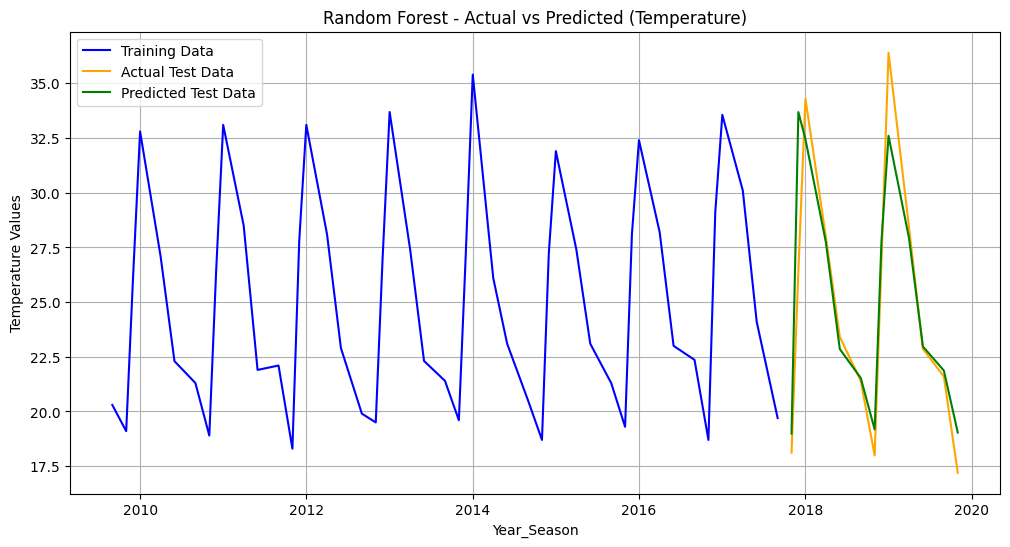

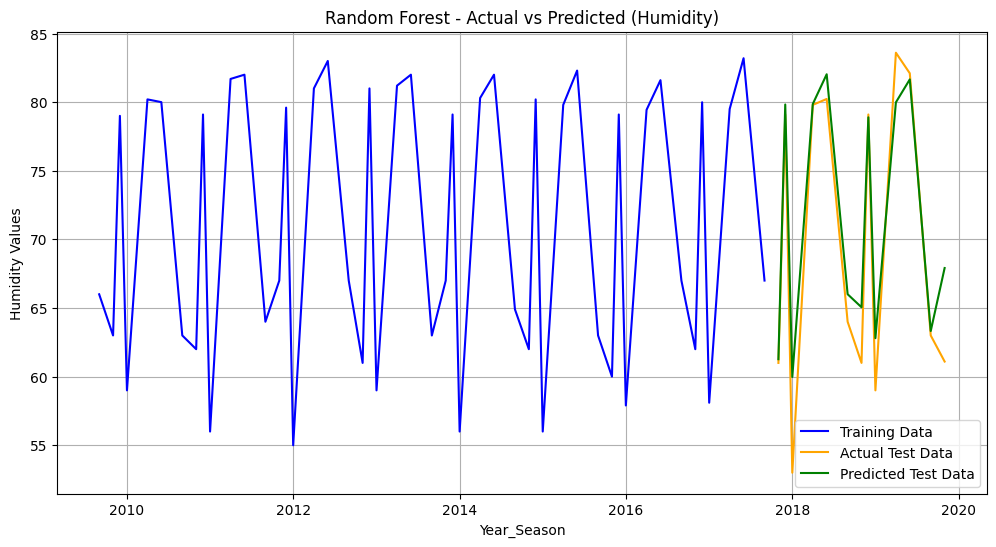

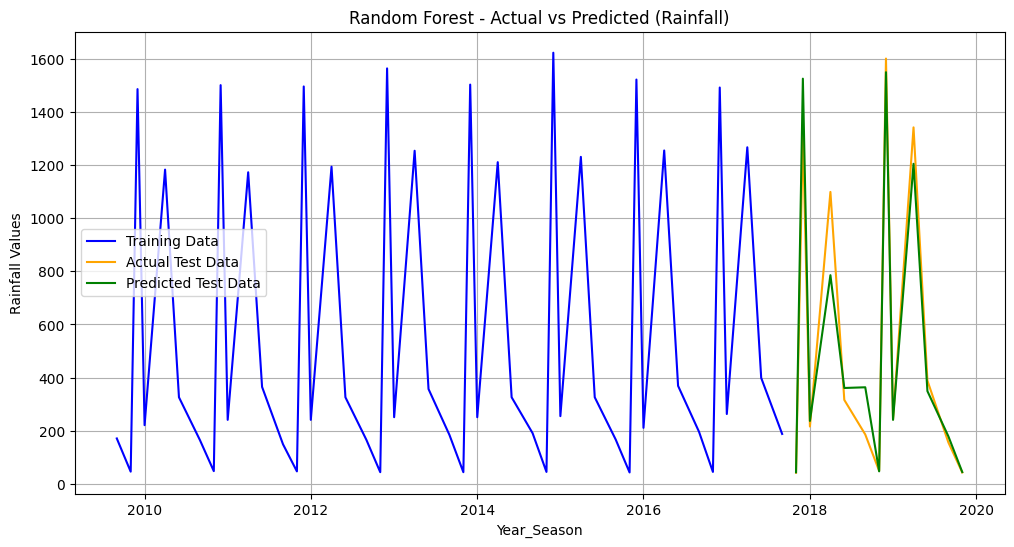

Temperature Model Evaluation Metrics: {'Mean Absolute Error (MAE)': 1.500323076923069, 'Root Mean Squared Error (RMSE)': 2.4470641332641243, 'R-squared (R²)': 0.819391655809862}
Humidity Model Evaluation Metrics: {'Mean Absolute Error (MAE)': 2.3928461538461496, 'Root Mean Squared Error (RMSE)': 3.3659375822632835, 'R-squared (R²)': 0.8971969234399277}
Rainfall Model Evaluation Metrics: {'Mean Absolute Error (MAE)': 78.37538461538462, 'Root Mean Squared Error (RMSE)': 123.14302897287926, 'R-squared (R²)': 0.9503181104862867}


In [202]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math
import pandas as pd

# Function to create lagged features and target
def create_lagged_features(data, lags=3):
    lagged_data = pd.DataFrame({f'lag_{i}': data.shift(i) for i in range(1, lags+1)})
    lagged_data['target'] = data.shift(-1)  # Set the target as the next time step's value
    return lagged_data.dropna()

# Function to train, evaluate, and plot results of a Random Forest model
def train_evaluate_and_plot(data, lags=3, variable_name="Variable"):
    # Step 1: Create lagged features and target
    lagged_data = create_lagged_features(data, lags)

    # Step 2: Train-Test Split
    train_size = int(len(lagged_data) * 0.8)
    train_data, test_data = lagged_data[:train_size], lagged_data[train_size:]

    # Step 3: Separate features and target
    X_train = train_data.drop('target', axis=1)
    y_train = train_data['target']
    X_test = test_data.drop('target', axis=1)
    y_test = test_data['target']

    # Step 4: Train Random Forest Model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Step 5: Forecast Using Random Forest
    rf_forecast = rf_model.predict(X_test)

    # Step 6: Plot Results
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index, y_train, label="Training Data", color="blue")
    plt.plot(test_data.index, y_test, label="Actual Test Data", color="orange")
    plt.plot(test_data.index, rf_forecast, label="Predicted Test Data", color="green")
    plt.legend()
    plt.title(f"Random Forest - Actual vs Predicted ({variable_name})")
    plt.xlabel("Year_Season")
    plt.ylabel(f"{variable_name} Values")
    plt.grid(True)
    plt.show()

    # Step 7: Evaluate Metrics
    mae = mean_absolute_error(y_test, rf_forecast)
    rmse = math.sqrt(mean_squared_error(y_test, rf_forecast))
    r2 = r2_score(y_test, rf_forecast)

    metrics = {
        "Mean Absolute Error (MAE)": mae,
        "Root Mean Squared Error (RMSE)": rmse,
        "R-squared (R²)": r2
    }

    return metrics

# Train, evaluate, and plot for each variable
temperature_metrics = train_evaluate_and_plot(temperature, lags=3, variable_name="Temperature")
humidity_metrics = train_evaluate_and_plot(humidity, lags=3, variable_name="Humidity")
rainfall_metrics = train_evaluate_and_plot(rainfall, lags=3, variable_name="Rainfall")

# Print evaluation metrics
print("Temperature Model Evaluation Metrics:", temperature_metrics)
print("Humidity Model Evaluation Metrics:", humidity_metrics)
print("Rainfall Model Evaluation Metrics:", rainfall_metrics)


<Figure size 1200x600 with 0 Axes>

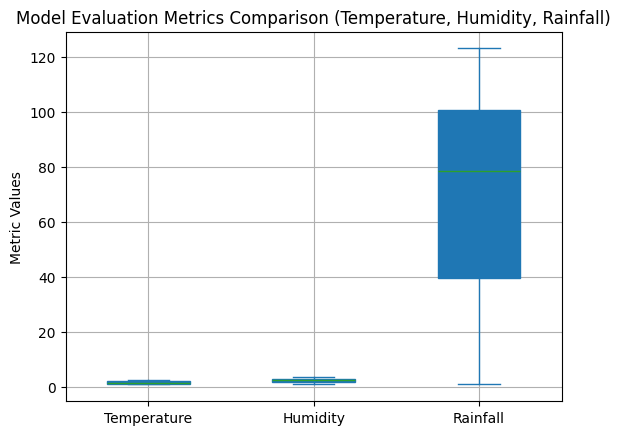

In [211]:
# Combine the metrics into a DataFrame for easier plotting
metrics_df = pd.DataFrame({
    "Temperature": [temperature_metrics["Mean Absolute Error (MAE)"], temperature_metrics["Root Mean Squared Error (RMSE)"], temperature_metrics["R-squared (R²)"]],
    "Humidity": [humidity_metrics["Mean Absolute Error (MAE)"], humidity_metrics["Root Mean Squared Error (RMSE)"], humidity_metrics["R-squared (R²)"]],
    "Rainfall": [rainfall_metrics["Mean Absolute Error (MAE)"], rainfall_metrics["Root Mean Squared Error (RMSE)"], rainfall_metrics["R-squared (R²)"]]
}, index=["MAE", "RMSE", "R²"])

# Plot box-and-whisker (box plot) for the metrics
plt.figure(figsize=(12, 6))
metrics_df.plot(kind='box', vert=True, patch_artist=True, widths=0.5)
plt.title("Model Evaluation Metrics Comparison (Temperature, Humidity, Rainfall)")
plt.ylabel("Metric Values")
plt.grid(True)
plt.show()




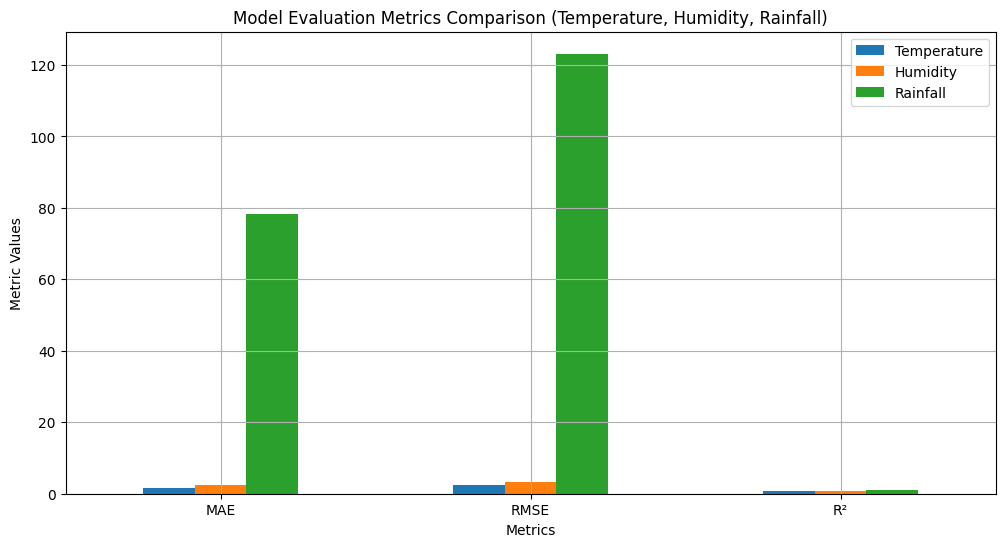

In [212]:
# Combine the metrics into a DataFrame for easier plotting
metrics_df = pd.DataFrame({
    "Temperature": [temperature_metrics["Mean Absolute Error (MAE)"], temperature_metrics["Root Mean Squared Error (RMSE)"], temperature_metrics["R-squared (R²)"]],
    "Humidity": [humidity_metrics["Mean Absolute Error (MAE)"], humidity_metrics["Root Mean Squared Error (RMSE)"], humidity_metrics["R-squared (R²)"]],
    "Rainfall": [rainfall_metrics["Mean Absolute Error (MAE)"], rainfall_metrics["Root Mean Squared Error (RMSE)"], rainfall_metrics["R-squared (R²)"]]
}, index=["MAE", "RMSE", "R²"])

# Plot bar charts for each metric
metrics_df.plot(kind='bar', figsize=(12, 6))
plt.title("Model Evaluation Metrics Comparison (Temperature, Humidity, Rainfall)")
plt.xlabel("Metrics")
plt.ylabel("Metric Values")
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

# **Plot with Shap**

SHAP Summary Plot for Temperature:


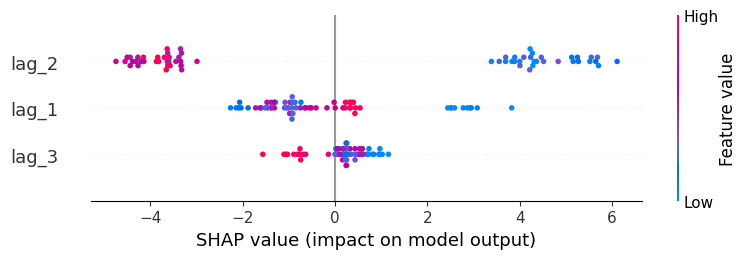

SHAP Summary Plot for Humidity:


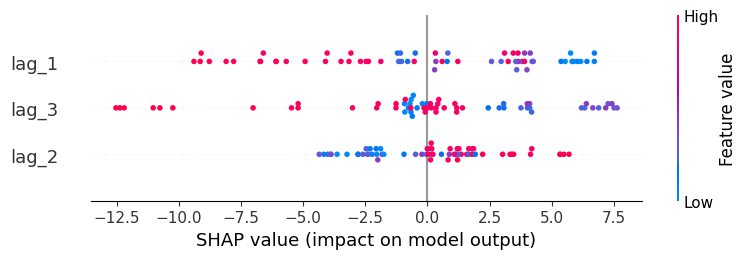

SHAP Summary Plot for Rainfall:


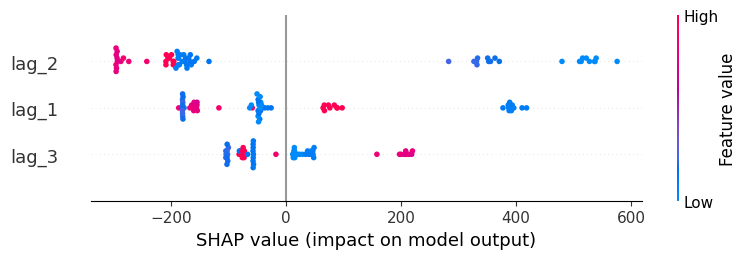

In [203]:
import shap
import matplotlib.pyplot as plt

# Function to plot SHAP summary after model evaluation
def plot_shap_summary(model, X):
    # Explain the model's predictions using SHAP
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    # Create a SHAP summary plot
    shap.summary_plot(shap_values, X)

# Call the SHAP summary plot after training and evaluating each model
temperature_data = create_lagged_features(temperature, lags=3)
humidity_data = create_lagged_features(humidity, lags=3)
rainfall_data = create_lagged_features(rainfall, lags=3)

# Extract features and targets for SHAP
X_temp = temperature_data.drop('target', axis=1)
y_temp = temperature_data['target']

X_hum = humidity_data.drop('target', axis=1)
y_hum = humidity_data['target']

X_rain = rainfall_data.drop('target', axis=1)
y_rain = rainfall_data['target']

# Train models again for SHAP (use the existing trained models if possible)
rf_temp = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_temp, y_temp)
rf_hum = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_hum, y_hum)
rf_rain = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_rain, y_rain)

# Plot SHAP summary for Temperature
print("SHAP Summary Plot for Temperature:")
plot_shap_summary(rf_temp, X_temp)

# Plot SHAP summary for Humidity
print("SHAP Summary Plot for Humidity:")
plot_shap_summary(rf_hum, X_hum)

# Plot SHAP summary for Rainfall
print("SHAP Summary Plot for Rainfall:")
plot_shap_summary(rf_rain, X_rain)


# *Catboost Installation***


In [174]:
pip install catboost


0:	learn: 4.5646603	test: 5.4834727	best: 5.4834727 (0)	total: 390us	remaining: 195ms
100:	learn: 0.3662689	test: 1.5119092	best: 1.5119092 (100)	total: 24.1ms	remaining: 95.2ms
200:	learn: 0.1253595	test: 1.5250881	best: 1.5059375 (110)	total: 50.4ms	remaining: 75ms
300:	learn: 0.0491242	test: 1.5458834	best: 1.5059375 (110)	total: 77.4ms	remaining: 51.2ms
400:	learn: 0.0191120	test: 1.5566156	best: 1.5059375 (110)	total: 104ms	remaining: 25.8ms
499:	learn: 0.0089593	test: 1.5613802	best: 1.5059375 (110)	total: 131ms	remaining: 0us

bestTest = 1.505937536
bestIteration = 110

Shrink model to first 111 iterations.


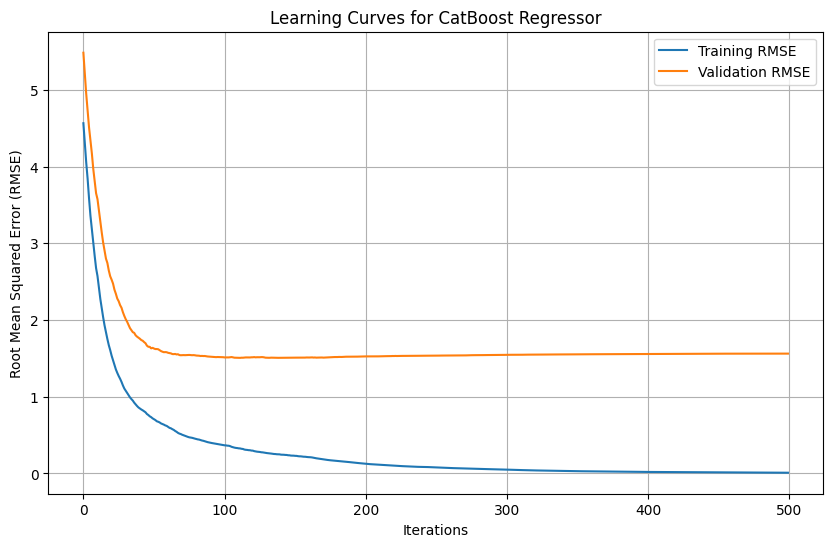

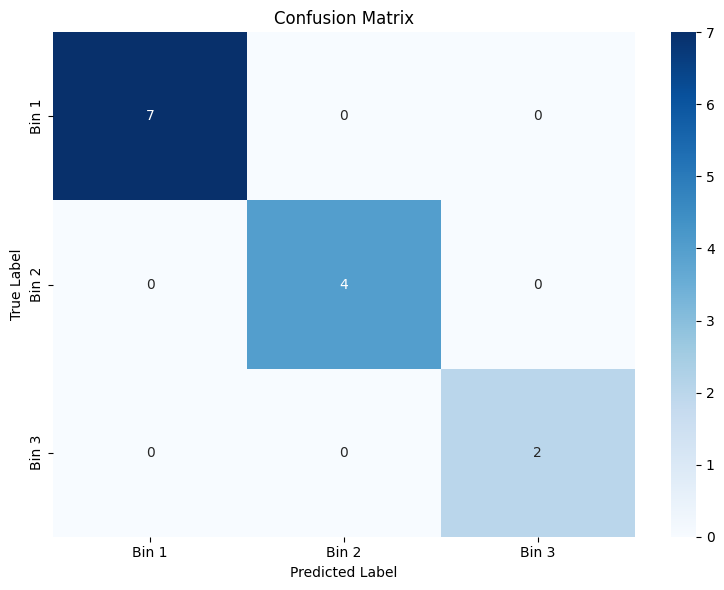

0:	learn: 9.4635241	test: 10.3103494	best: 10.3103494 (0)	total: 390us	remaining: 195ms
100:	learn: 0.5093614	test: 2.6267388	best: 2.5574514 (74)	total: 20.7ms	remaining: 81.7ms
200:	learn: 0.1772364	test: 2.7101546	best: 2.5574514 (74)	total: 41.2ms	remaining: 61.3ms
300:	learn: 0.0674043	test: 2.7329217	best: 2.5574514 (74)	total: 60.5ms	remaining: 40ms
400:	learn: 0.0257484	test: 2.7336005	best: 2.5574514 (74)	total: 81.7ms	remaining: 20.2ms
499:	learn: 0.0106139	test: 2.7324089	best: 2.5574514 (74)	total: 101ms	remaining: 0us

bestTest = 2.557451431
bestIteration = 74

Shrink model to first 75 iterations.


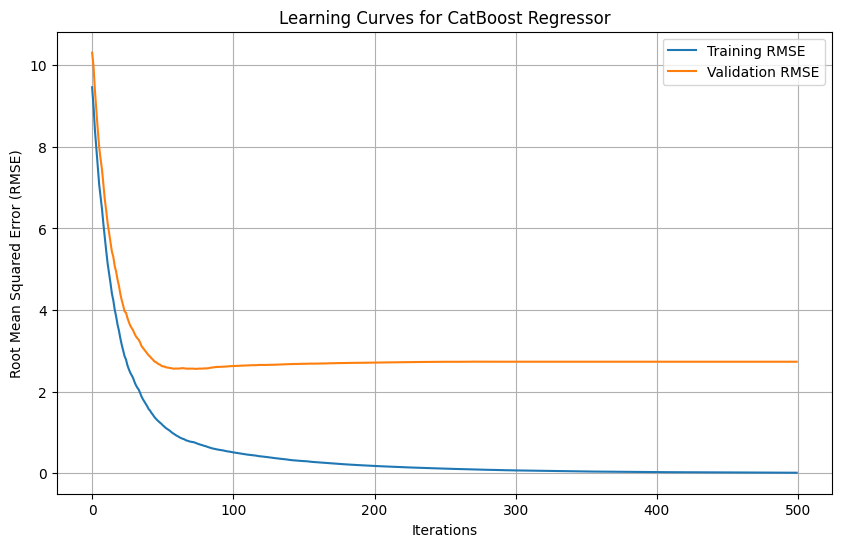

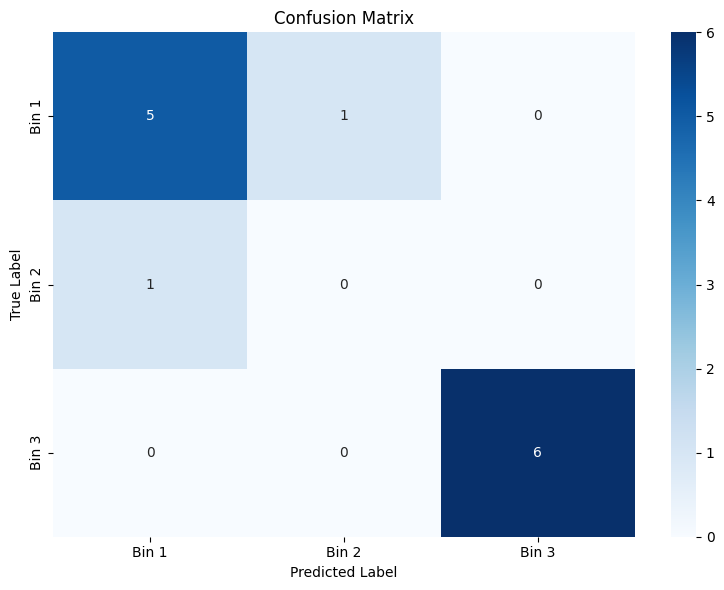

0:	learn: 525.8509046	test: 524.5217351	best: 524.5217351 (0)	total: 838us	remaining: 418ms
100:	learn: 22.1972296	test: 116.1729262	best: 116.1729262 (100)	total: 24.6ms	remaining: 97.1ms
200:	learn: 10.6755351	test: 114.6377201	best: 114.6377201 (200)	total: 47.5ms	remaining: 70.7ms
300:	learn: 5.3559841	test: 114.0708103	best: 114.0577221 (290)	total: 70.2ms	remaining: 46.4ms
400:	learn: 2.9811989	test: 113.8269850	best: 113.8269850 (400)	total: 92.5ms	remaining: 22.8ms
499:	learn: 1.6205982	test: 113.8186475	best: 113.7880342 (463)	total: 115ms	remaining: 0us

bestTest = 113.7880342
bestIteration = 463

Shrink model to first 464 iterations.


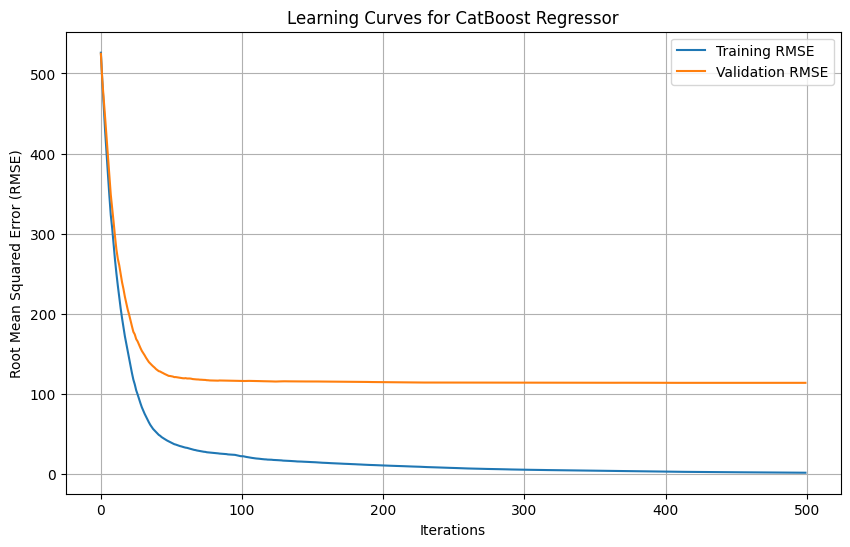

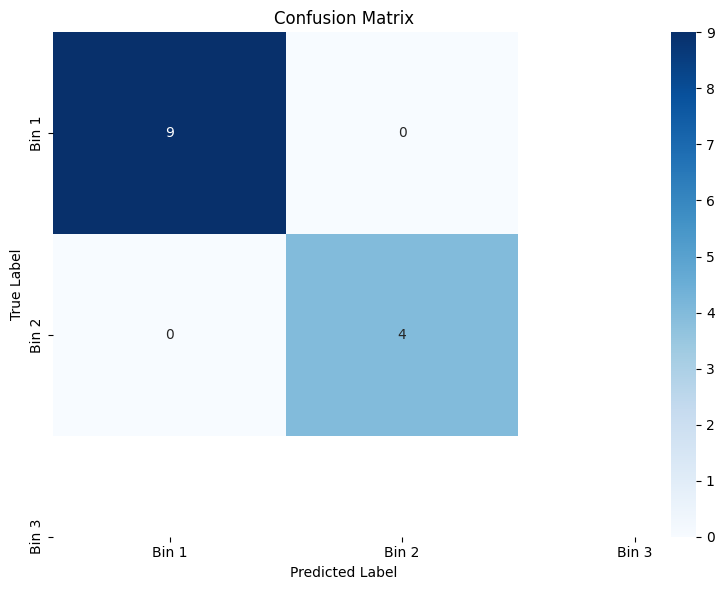

Temperature Model Evaluation Metrics (CatBoost): {'Mean Absolute Error (MAE)': 1.1083047529015748, 'Root Mean Squared Error (RMSE)': 1.5059374372619538, 'R-squared (R²)': 0.9315992336304743}
Humidity Model Evaluation Metrics (CatBoost): {'Mean Absolute Error (MAE)': 1.885620430701471, 'Root Mean Squared Error (RMSE)': 2.557451545087129, 'R-squared (R²)': 0.9406516261640239}
Rainfall Model Evaluation Metrics (CatBoost): {'Mean Absolute Error (MAE)': 83.45707090103753, 'Root Mean Squared Error (RMSE)': 113.78803416651256, 'R-squared (R²)': 0.9575799056585824}


In [204]:
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
import math
import pandas as pd
import seaborn as sns

# Function to create lagged features and target
def create_lagged_features(data, lags=3):
    # Create lagged features
    lagged_data = pd.DataFrame({f'lag_{i}': data.shift(i) for i in range(1, lags+1)})
    lagged_data['target'] = data.shift(-1)  # Set the target as the next time step's value
    # Drop rows with NaN values created by shifting
    return lagged_data.dropna()

# Function to train and evaluate a CatBoost model
def train_and_evaluate_model_catboost(data, lags=3, bins=3):
    # Step 1: Create lagged features and target
    lagged_data = create_lagged_features(data, lags)

    # Step 2: Train-Test Split
    train_size = int(len(lagged_data) * 0.8)
    train_data, test_data = lagged_data[:train_size], lagged_data[train_size:]

    # Step 3: Separate features (X_train) and target (y_train) for training data
    X_train = train_data.drop('target', axis=1)  # Features (lagged values)
    y_train = train_data['target']  # Target (next time step's value)

    # Step 4: Separate features (X_test) and target (y_test) for testing data
    X_test = test_data.drop('target', axis=1)  # Features (lagged values)
    y_test = test_data['target']  # Target (next time step's value)

    # Step 5: Train CatBoost Model with eval_set to track training and validation RMSE
    catboost_model = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, random_seed=42, verbose=100, eval_metric="RMSE")

    catboost_model.fit(
        X_train, y_train,
        eval_set=(X_test, y_test),
        plot=False  # Disable CatBoost's built-in plot since we'll plot manually
    )

    # Step 6: Extract training and validation RMSE (learning curves)
    eval_results = catboost_model.get_evals_result()
    train_rmse = eval_results['learn']['RMSE']
    test_rmse = eval_results['validation']['RMSE']

    # Step 7: Plot Learning Curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(test_rmse, label='Validation RMSE')
    plt.xlabel('Iterations')
    plt.ylabel('Root Mean Squared Error (RMSE)')
    plt.title('Learning Curves for CatBoost Regressor')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Step 8: Forecast Using CatBoost
    catboost_forecast = catboost_model.predict(X_test)

    # Step 9: Discretize the continuous values into bins
    y_test_binned = pd.cut(y_test, bins=bins, labels=False)  # Binned actual values
    catboost_forecast_binned = pd.cut(catboost_forecast, bins=bins, labels=False)  # Binned predicted values

    # Step 10: Compute confusion matrix
    cm = confusion_matrix(y_test_binned, catboost_forecast_binned)

    # Step 11: Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[f'Bin {i+1}' for i in range(bins)], yticklabels=[f'Bin {i+1}' for i in range(bins)])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    # Step 12: Evaluate Metrics
    mae = mean_absolute_error(y_test, catboost_forecast)
    rmse = math.sqrt(mean_squared_error(y_test, catboost_forecast))
    r2 = r2_score(y_test, catboost_forecast)

    # Return evaluation metrics
    metrics = {
        "Mean Absolute Error (MAE)": mae,
        "Root Mean Squared Error (RMSE)": rmse,
        "R-squared (R²)": r2
    }

    return metrics

# Example usage with temperature, humidity, and rainfall data:
# Assuming 'temperature', 'humidity', and 'rainfall' are your data series
temperature_metrics_catboost = train_and_evaluate_model_catboost(temperature, lags=3, bins=3)
humidity_metrics_catboost = train_and_evaluate_model_catboost(humidity, lags=3, bins=3)
rainfall_metrics_catboost = train_and_evaluate_model_catboost(rainfall, lags=3, bins=3)

# Print the evaluation metrics for each variable
print("Temperature Model Evaluation Metrics (CatBoost):", temperature_metrics_catboost)
print("Humidity Model Evaluation Metrics (CatBoost):", humidity_metrics_catboost)
print("Rainfall Model Evaluation Metrics (CatBoost):", rainfall_metrics_catboost)


# **Shap Plot**

SHAP Summary Plot for Temperature (CatBoost):


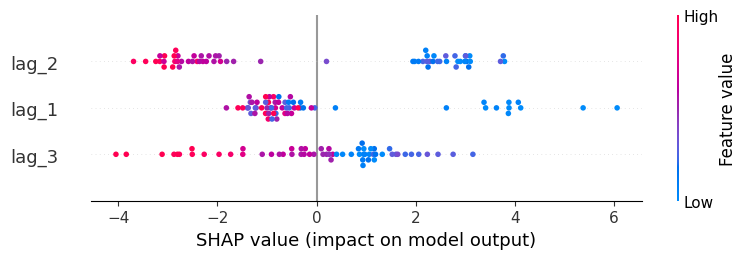

SHAP Summary Plot for Humidity (CatBoost):


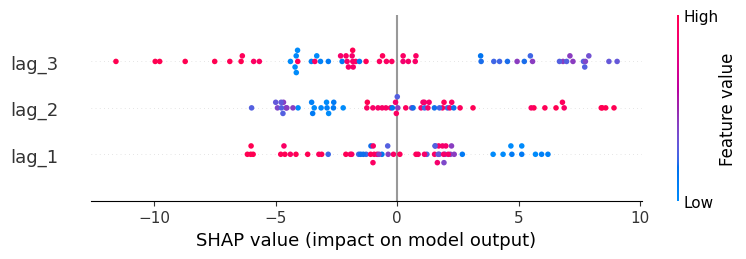

SHAP Summary Plot for Rainfall (CatBoost):


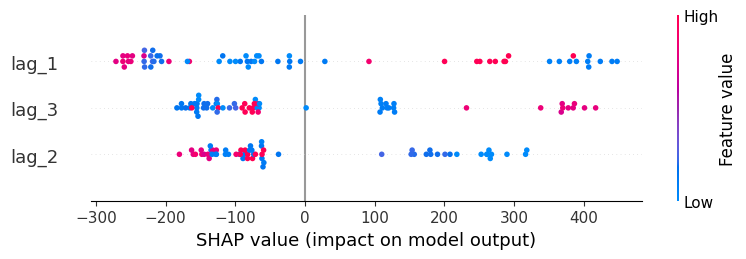

In [205]:
import shap

# Function to plot SHAP summary for CatBoost
def plot_shap_summary_catboost(model, X):
    # Explain the model's predictions using SHAP
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    # Create a SHAP summary plot
    shap.summary_plot(shap_values, X)

# Example usage with SHAP
temperature_data = create_lagged_features(temperature, lags=3)
humidity_data = create_lagged_features(humidity, lags=3)
rainfall_data = create_lagged_features(rainfall, lags=3)

# Extract features for SHAP
X_temp = temperature_data.drop('target', axis=1)
y_temp = temperature_data['target']

X_hum = humidity_data.drop('target', axis=1)
y_hum = humidity_data['target']

X_rain = rainfall_data.drop('target', axis=1)
y_rain = rainfall_data['target']

# Train models for SHAP
catboost_temp = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, random_seed=42, verbose=0).fit(X_temp, y_temp)
catboost_hum = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, random_seed=42, verbose=0).fit(X_hum, y_hum)
catboost_rain = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, random_seed=42, verbose=0).fit(X_rain, y_rain)

# Plot SHAP summary for Temperature
print("SHAP Summary Plot for Temperature (CatBoost):")
plot_shap_summary_catboost(catboost_temp, X_temp)

# Plot SHAP summary for Humidity
print("SHAP Summary Plot for Humidity (CatBoost):")
plot_shap_summary_catboost(catboost_hum, X_hum)

# Plot SHAP summary for Rainfall
print("SHAP Summary Plot for Rainfall (CatBoost):")
plot_shap_summary_catboost(catboost_rain, X_rain)


# **Xgboost**

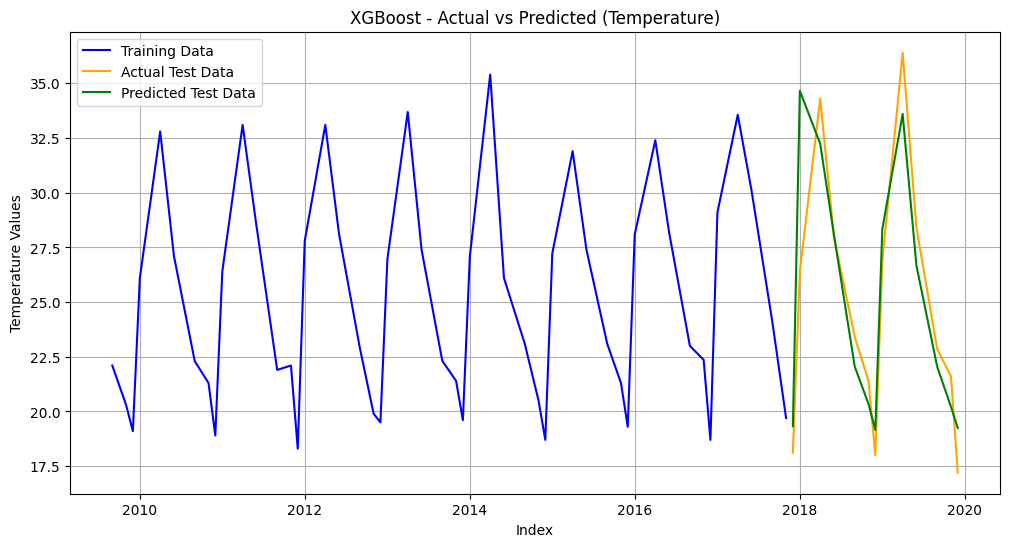

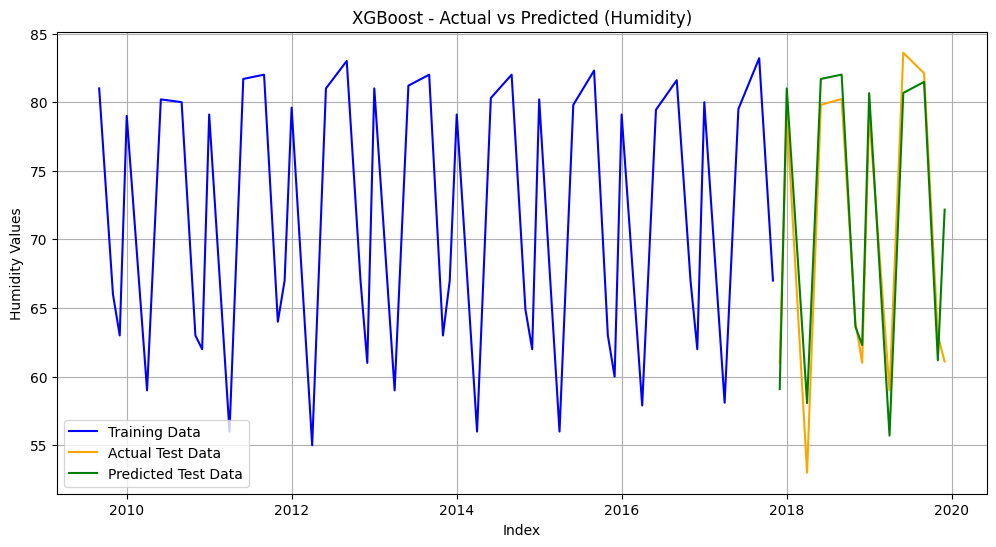

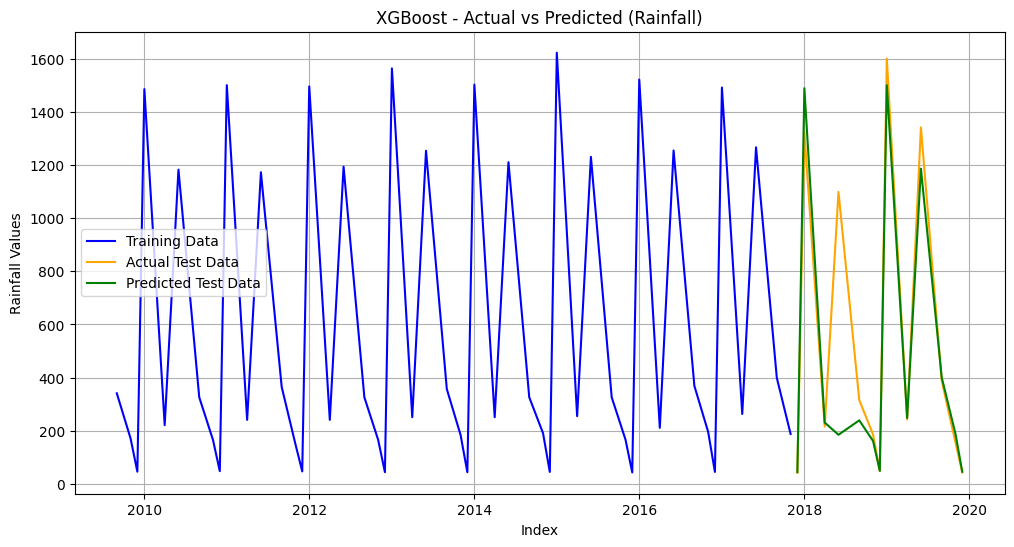

Temperature Model Evaluation Metrics: {'Mean Absolute Error (MAE)': 1.9568971898005556, 'Root Mean Squared Error (RMSE)': 2.742961454434281, 'R-squared (R²)': 0.7730728194587239}
Humidity Model Evaluation Metrics: {'Mean Absolute Error (MAE)': 2.7294268329326923, 'Root Mean Squared Error (RMSE)': 3.8183138906235636, 'R-squared (R²)': 0.8677068826424614}
Rainfall Model Evaluation Metrics: {'Mean Absolute Error (MAE)': 116.01285552978516, 'Root Mean Squared Error (RMSE)': 263.95983951161963, 'R-squared (R²)': 0.7717272043228149}


In [206]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

# Function to create lagged features and target
def create_lagged_features(data, lags=3):
    lagged_data = pd.DataFrame({f'lag_{i}': data.shift(i) for i in range(1, lags+1)})
    lagged_data['target'] = data
    return lagged_data.dropna()

# Function to train, evaluate, and plot results of an XGBoost model
def train_evaluate_and_plot(data, lags=3, variable_name="Variable"):
    # Step 1: Create lagged features and target
    lagged_data = create_lagged_features(data, lags)

    # Step 2: Train-Test Split
    train_size = int(len(lagged_data) * 0.8)
    train_data, test_data = lagged_data[:train_size], lagged_data[train_size:]

    # Step 3: Separate features and target
    X_train = train_data.drop('target', axis=1)
    y_train = train_data['target']
    X_test = test_data.drop('target', axis=1)
    y_test = test_data['target']

    # Step 4: Train XGBoost Model
    xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
    xgb_model.fit(X_train, y_train)

    # Step 5: Forecast Using XGBoost
    xgb_forecast = xgb_model.predict(X_test)

    # Step 6: Plot Results
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index, y_train, label="Training Data", color="blue")
    plt.plot(test_data.index, y_test, label="Actual Test Data", color="orange")
    plt.plot(test_data.index, xgb_forecast, label="Predicted Test Data", color="green")
    plt.legend()
    plt.title(f"XGBoost - Actual vs Predicted ({variable_name})")
    plt.xlabel("Index")
    plt.ylabel(f"{variable_name} Values")
    plt.grid(True)
    plt.show()

    # Step 7: Evaluate Metrics
    mae = mean_absolute_error(y_test, xgb_forecast)
    rmse = math.sqrt(mean_squared_error(y_test, xgb_forecast))
    r2 = r2_score(y_test, xgb_forecast)

    metrics = {
        "Mean Absolute Error (MAE)": mae,
        "Root Mean Squared Error (RMSE)": rmse,
        "R-squared (R²)": r2
    }

    return metrics

# Train, evaluate, and plot for each variable
temperature_metrics = train_evaluate_and_plot(temperature, lags=3, variable_name="Temperature")
humidity_metrics = train_evaluate_and_plot(humidity, lags=3, variable_name="Humidity")
rainfall_metrics = train_evaluate_and_plot(rainfall, lags=3, variable_name="Rainfall")

# Print evaluation metrics
print("Temperature Model Evaluation Metrics:", temperature_metrics)
print("Humidity Model Evaluation Metrics:", humidity_metrics)
print("Rainfall Model Evaluation Metrics:", rainfall_metrics)


In [ ]:
climate_data.to_csv('sorted_burdwan_crop.csv', index=False)